* Load multiple DiT models of different random seed. 
* compare weights? should not be the same 
* compar linkage from initial noise to final outcome

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
sys.path.append("/n/home12/binxuwang/Github/DiT")

In [4]:
import time
import os
from os.path import join
import pickle as pkl
import torch
import torch as th
from tqdm.auto import tqdm
import numpy as np
import seaborn as sns
import einops
import matplotlib.pyplot as plt
from collections import defaultdict
from easydict import EasyDict as edict
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# from train_edm import create_model, edm_sampler, EDM
# from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import check_r3_r2_batch, infer_rule_from_sample_batch, compute_rule_statistics
import circuit_toolkit
from circuit_toolkit.layer_hook_utils import print_specific_layer, get_module_name_shapes, featureFetcher_module

In [5]:

# abstract RAVEN dataset
dataset_Xmean = th.tensor([1.5, 2.5, 2.5]).view(1, 3, 1, 1).to("cuda")
dataset_Xstd = th.tensor([2.5, 3.5, 3.5]).view(1, 3, 1, 1).to("cuda")

In [6]:
DiT_exproot = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results'

In [7]:
!ls -d $DiT_exproot/*rep* | xargs -n 1 basename


109-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1600
110-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1600
111-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601
111-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601
112-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601
113-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601


In [8]:
expnames = [
    "109-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1600",
    "111-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601",
    "113-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601",
    "110-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1600",
    "111-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601",
    "112-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601"
]

In [9]:
from diffusion import create_diffusion
from models import DiT

DiT_configs = {
    "DiT_XL_1": {"depth": 28, "hidden_size": 1152, "patch_size": 1, "num_heads": 16},
    "DiT_XL_3": {"depth": 28, "hidden_size": 1152, "patch_size": 3, "num_heads": 16},
    "DiT_L_1": {"depth": 24, "hidden_size": 1024, "patch_size": 1, "num_heads": 16},
    "DiT_L_3": {"depth": 24, "hidden_size": 1024, "patch_size": 3, "num_heads": 16},
    "DiT_B_1": {"depth": 12, "hidden_size": 768, "patch_size": 1, "num_heads": 12},
    "DiT_B_3": {"depth": 12, "hidden_size": 768, "patch_size": 3, "num_heads": 12},
    "DiT_S_1": {"depth": 12, "hidden_size": 384, "patch_size": 1, "num_heads": 6},
    "DiT_S_3": {"depth": 12, "hidden_size": 384, "patch_size": 3, "num_heads": 6},
}

def load_DiT_model(expname, ckpt_step, use_ema=True, 
                   cfg = "DiT_S_1",
                   class_dropout_prob = 1.0,
                   num_classes = 0):
    model_cfg = DiT_configs[cfg]
    model_DiT = DiT(input_size=9,
                in_channels=3, **model_cfg,
                mlp_ratio=4.0,
                class_dropout_prob=class_dropout_prob,
                num_classes=num_classes,
                learn_sigma=True,)

    expdir = join(DiT_exproot, expname)
    ckptdir = join(expdir, "checkpoints")
    ckpt_path = join(ckptdir, f"{ckpt_step}.pt")
    state_dict = th.load(ckpt_path)
    model_DiT.load_state_dict(state_dict['ema' if use_ema else 'model'])
    model_DiT.to("cuda").eval()
    return model_DiT

In [25]:
model_DiT = load_DiT_model(expnames[0], 1000000, use_ema=True, cfg="DiT_S_1")

In [27]:
diffusion_eval = create_diffusion(timestep_respacing="ddim100")  # default: ddim100
batch_size = 512
noise = th.randn(batch_size, 3, 9, 9, device="cuda", generator=th.Generator(device="cuda").manual_seed(0))
y = th.zeros(batch_size, dtype=torch.int, device="cuda")
model_kwargs = dict(y=y)
with th.no_grad():
    samples = diffusion_eval.ddim_sample_loop(model_DiT, noise=noise, shape=(batch_size, 3, 9, 9), clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

C3: 337/512 (0.66), C3 + C2: 393/512 (0.77), AnyValid: 1222/1536 (0.80)


### Test the reproducibility across training runs

In [38]:
model_DiT1 = load_DiT_model(expnames[1], 1000000, use_ema=True, cfg="DiT_S_1")
model_DiT2 = load_DiT_model(expnames[2], 1000000, use_ema=True, cfg="DiT_S_1")

In [73]:
diffusion_eval = create_diffusion(timestep_respacing="ddim100")  # default: ddim100

batch_size = 2048 * 5
noise = th.randn(batch_size, 3, 9, 9, device="cuda", generator=th.Generator(device="cuda").manual_seed(42))
y = th.zeros(batch_size, dtype=torch.int, device="cuda")
model_kwargs = dict(y=y)

with th.no_grad():
    samples1 = diffusion_eval.ddim_sample_loop(model_DiT1, noise=noise, shape=(batch_size, 3, 9, 9), clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
samples1 = ((samples1.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list1, r2_list1, rule_col1 = infer_rule_from_sample_batch(samples1)
C3_count1, C2_count1, anyvalid_count1, total1 = compute_rule_statistics(r3_list1, r2_list1, rule_col1, verbose=True)

with th.no_grad():
    samples2 = diffusion_eval.ddim_sample_loop(model_DiT2, noise=noise, shape=(batch_size, 3, 9, 9), clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
samples2 = ((samples2.detach() * dataset_Xstd) + dataset_Xmean).cpu()
r3_list2, r2_list2, rule_col2 = infer_rule_from_sample_batch(samples2)
C3_count2, C2_count2, anyvalid_count2, total2 = compute_rule_statistics(r3_list2, r2_list2, rule_col2, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

C3: 6505/10240 (0.64), C3 + C2: 7645/10240 (0.75), AnyValid: 23763/30720 (0.77)


  0%|          | 0/100 [00:00<?, ?it/s]

C3: 6564/10240 (0.64), C3 + C2: 7773/10240 (0.76), AnyValid: 24021/30720 (0.78)


In [15]:
def compute_confidence_interval(n, k, confidence=0.95, verbose=True):
    """Compute confidence interval for binomial proportion using beta distribution
    
    Args:
        n (int): Total number of trials
        k (int): Number of successes
        confidence (float): Confidence level (default 0.95)
        verbose (bool): Whether to print the result (default True)
        
    Returns:
        tuple: Lower and upper bounds of confidence interval
    """
    from scipy.stats import beta
    a = k + 1  # alpha parameter for beta distribution
    b = n - k + 1  # beta parameter
    ci = beta.interval(confidence, a, b)
    if verbose:
        print(f"ratio {k/n:.3f} {confidence*100}% CI: ({ci[0]:.3f}, {ci[1]:.3f})")
    return ci

In [93]:
compute_confidence_interval(total1, C3_count1, confidence=0.95, verbose=True)
compute_confidence_interval(total2, C3_count2, confidence=0.95, verbose=True)

ratio 0.635 95.0% CI: (0.626, 0.645)
ratio 0.641 95.0% CI: (0.632, 0.650)


(0.6316722686331505, 0.6502517549080044)

In [74]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning"
outdir = join(figroot, "Diffusion_reproducibility_analysis")
os.makedirs(outdir, exist_ok=True)

In [75]:
# save the samples with the same seed
th.save(samples1, join(outdir, f"samples1_{expnames[0]}.pth"))
th.save({"c3": r3_list1, "c2": r2_list1, "rule": rule_col1,
         "C3_count": C3_count1, "C2_count": C2_count1, "anyvalid_count": anyvalid_count1, "total": total1
         }, join(outdir, f"eval_samples1_{expnames[0]}.pkl"))
th.save(samples2, join(outdir, f"samples2_{expnames[1]}.pth"))
th.save({"c3": r3_list2, "c2": r2_list2, "rule": rule_col2,
         "C3_count": C3_count2, "C2_count": C2_count2, "anyvalid_count": anyvalid_count2, "total": total2
         }, join(outdir, f"eval_samples2_{expnames[1]}.pkl"))


In [76]:
!du -sh $outdir

16M	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Diffusion_reproducibility_analysis


Check the reproducibility of samples

In [94]:
# check if the samples entries are the same
entry_match_tsr = (samples1.int() == samples2.int())
# see how many rules are the same r3
sample_match_tsr = entry_match_tsr.all(dim=(1,2,3))
sample_match_frac = sample_match_tsr.sum() / batch_size
# see how many entries are the same
entry_match_frac = entry_match_tsr.sum() / entry_match_tsr.numel()
print(f"sample match frac: {sample_match_frac:.2f} ({sample_match_tsr.sum()}/{batch_size})")
print(f"entry match frac: {entry_match_frac:.2f} ({entry_match_tsr.sum()}/{entry_match_tsr.numel()})")

sample match frac: 0.00 (0/10240)
entry match frac: 0.73 (1822352/2488320)


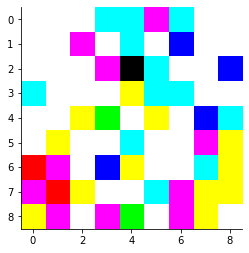

In [78]:
entry_match_tsr[2] 
# show this as an image
plt.imshow(entry_match_tsr[2].permute(1,2,0).float().cpu().numpy())

In [95]:
# see how many rules are the same r3
C3_rule_match_vec = [set(c3_1) == set(c3_2) for c3_1, c3_2 in zip(r3_list1, r3_list2)]
C3_rule_match_frac = sum(C3_rule_match_vec) / len(C3_rule_match_vec)
print(f"Sample C3 rule match frac: {C3_rule_match_frac:.3f} ({sum(C3_rule_match_vec)}/{len(C3_rule_match_vec)})")

Sample C3 rule match frac: 0.811 (8309/10240)


In [96]:
# see how many rules are the same r3
C2_rule_match_vec = [set(c2_1) == set(c2_2) for c2_1, c2_2 in zip(r2_list1, r2_list2)]
C2_rule_match_frac = sum(C2_rule_match_vec) / len(C2_rule_match_vec)
print(f"Sample C2 rule match frac: {C2_rule_match_frac:.3f} ({sum(C2_rule_match_vec)}/{len(C2_rule_match_vec)})")

Sample C2 rule match frac: 0.844 (8645/10240)


In [97]:
rule_col1_flatten = [rule for sublist in rule_col1 for rule in sublist]
rule_col2_flatten = [rule for sublist in rule_col2 for rule in sublist]
rule_match_vec = [set(rule_1) == set(rule_2) for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
rule_match_frac = sum(rule_match_vec) / len(rule_match_vec)
print(f"Row all rule match frac: {rule_match_frac:.3f} ({sum(rule_match_vec)}/{len(rule_match_vec)})")
# how many rows have at least one rule match intersection in the two sets
rule_intersect_vec = [len(set(rule_1) & set(rule_2)) > 0 
     for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
rule_intersect_w0_vec = [len(set(rule_1) & set(rule_2)) > 0 or ( len(rule_2)==0 and len(rule_1)==0 )
     for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
rule_intersect_frac = sum(rule_intersect_vec) / len(rule_intersect_vec)
rule_intersect_w0_frac = sum(rule_intersect_w0_vec) / len(rule_intersect_w0_vec)
print(f"Row any rule overlap frac: {rule_intersect_frac:.3f} ({sum(rule_intersect_vec)}/{len(rule_intersect_vec)})")
print(f"Row any rule overlap with empty frac: {rule_intersect_w0_frac:.3f} ({sum(rule_intersect_w0_vec)}/{len(rule_intersect_w0_vec)})")


Row all rule match frac: 0.717 (22037/30720)
Row any rule overlap frac: 0.629 (19332/30720)
Row any rule overlap with empty frac: 0.785 (24112/30720)


### Statistical splits of data

In [ ]:
# samples1 = ((samples1.detach() * dataset_Xstd) + dataset_Xmean).cpu()
for split_idx in range(5):
    r3_list_split, r2_list_split, rule_col_split = infer_rule_from_sample_batch(samples1[split_idx*batch_size//5:(split_idx+1)*batch_size//5])
    C3_count_split, C2_count_split, anyvalid_count_split, total_split = compute_rule_statistics(r3_list_split, r2_list_split, rule_col_split, verbose=True)

C3: 1324/2048 (0.65), C3 + C2: 1552/2048 (0.76), AnyValid: 4813/6144 (0.78)
C3: 1310/2048 (0.64), C3 + C2: 1546/2048 (0.75), AnyValid: 4784/6144 (0.78)
C3: 1284/2048 (0.63), C3 + C2: 1528/2048 (0.75), AnyValid: 4735/6144 (0.77)
C3: 1282/2048 (0.63), C3 + C2: 1496/2048 (0.73), AnyValid: 4689/6144 (0.76)
C3: 1305/2048 (0.64), C3 + C2: 1523/2048 (0.74), AnyValid: 4742/6144 (0.77)


In [ ]:
# samples1 = ((samples1.detach() * dataset_Xstd) + dataset_Xmean).cpu()
for split_idx in range(5):
    r3_list_split, r2_list_split, rule_col_split = infer_rule_from_sample_batch(samples2[split_idx*batch_size//5:(split_idx+1)*batch_size//5])
    C3_count_split, C2_count_split, anyvalid_count_split, total_split = compute_rule_statistics(r3_list_split, r2_list_split, rule_col_split, verbose=True)

C3: 1324/2048 (0.65), C3 + C2: 1560/2048 (0.76), AnyValid: 4807/6144 (0.78)
C3: 1323/2048 (0.65), C3 + C2: 1579/2048 (0.77), AnyValid: 4856/6144 (0.79)
C3: 1300/2048 (0.63), C3 + C2: 1545/2048 (0.75), AnyValid: 4800/6144 (0.78)
C3: 1297/2048 (0.63), C3 + C2: 1534/2048 (0.75), AnyValid: 4736/6144 (0.77)
C3: 1320/2048 (0.64), C3 + C2: 1555/2048 (0.76), AnyValid: 4822/6144 (0.78)


### Summary across multiple runs

In [12]:
def eval_sample_match(samples1, samples2):
    stats_dict = edict()
    C3_list1, C2_list1, rule_col1 = infer_rule_from_sample_batch(samples1)
    C3_list2, C2_list2, rule_col2 = infer_rule_from_sample_batch(samples2)
    batch_size = samples1.shape[0]
    # check if the samples entries are the same
    entry_match_tsr = (samples1.int() == samples2.int())
    # see how many rules are the same r3
    sample_match_tsr = entry_match_tsr.all(dim=(1,2,3))
    sample_match_frac = sample_match_tsr.sum() / batch_size
    # see how many entries are the same
    entry_match_frac = entry_match_tsr.sum() / entry_match_tsr.numel()
    print(f"sample match frac: {sample_match_frac:.2f} ({sample_match_tsr.sum()}/{batch_size})")
    print(f"entry match frac: {entry_match_frac:.2f} ({entry_match_tsr.sum()}/{entry_match_tsr.numel()})")
    stats_dict["entry_match_frac"] = entry_match_frac
    stats_dict["entry_match_cnt"] = entry_match_tsr.sum()
    stats_dict["entry_match_total"] = entry_match_tsr.numel()
    stats_dict["sample_match_frac"] = sample_match_frac
    stats_dict["sample_match_cnt"] = sample_match_tsr.sum()
    stats_dict["sample_match_total"] = batch_size
    # see how many samples have the same C3 rules
    C3_rule_match_vec = [set(c3_1) == set(c3_2) for c3_1, c3_2 in zip(C3_list1, C3_list2)]
    C3_rule_match_frac = sum(C3_rule_match_vec) / len(C3_rule_match_vec)
    print(f"Sample C3 rule match frac: {C3_rule_match_frac:.3f} ({sum(C3_rule_match_vec)}/{len(C3_rule_match_vec)})")
    stats_dict["C3_rule_match_frac"] = C3_rule_match_frac
    stats_dict["C3_rule_match_cnt"] = sum(C3_rule_match_vec)
    stats_dict["C3_rule_match_total"] = len(C3_rule_match_vec)
    # see how many samples have the same C2 rules
    C2_rule_match_vec = [set(c2_1) == set(c2_2) for c2_1, c2_2 in zip(C2_list1, C2_list2)]
    C2_rule_match_frac = sum(C2_rule_match_vec) / len(C2_rule_match_vec)
    print(f"Sample C2 rule match frac: {C2_rule_match_frac:.3f} ({sum(C2_rule_match_vec)}/{len(C2_rule_match_vec)})")
    stats_dict["C2_rule_match_frac"] = C2_rule_match_frac
    stats_dict["C2_rule_match_cnt"] = sum(C2_rule_match_vec)
    stats_dict["C2_rule_match_total"] = len(C2_rule_match_vec)
    # see how many rows have the same rule set
    rule_col1_flatten = [rule for sublist in rule_col1 for rule in sublist]
    rule_col2_flatten = [rule for sublist in rule_col2 for rule in sublist]
    rule_match_vec = [set(rule_1) == set(rule_2) for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
    rule_match_frac = sum(rule_match_vec) / len(rule_match_vec)
    print(f"Row all rule match frac: {rule_match_frac:.3f} ({sum(rule_match_vec)}/{len(rule_match_vec)})")
    stats_dict["rule_match_frac"] = rule_match_frac
    stats_dict["rule_match_cnt"] = sum(rule_match_vec)
    stats_dict["rule_match_total"] = len(rule_match_vec)
    # how many rows have at least one rule match intersection in the two sets
    rule_intersect_vec = [len(set(rule_1) & set(rule_2)) > 0 
        for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
    rule_intersect_w0_vec = [len(set(rule_1) & set(rule_2)) > 0 or ( len(rule_2)==0 and len(rule_1)==0 )
        for rule_1, rule_2 in zip(rule_col1_flatten, rule_col2_flatten)]
    rule_intersect_frac = sum(rule_intersect_vec) / len(rule_intersect_vec)
    rule_intersect_w0_frac = sum(rule_intersect_w0_vec) / len(rule_intersect_w0_vec)
    print(f"Row any rule overlap frac: {rule_intersect_frac:.3f} ({sum(rule_intersect_vec)}/{len(rule_intersect_vec)})")
    print(f"Row any rule overlap with empty frac: {rule_intersect_w0_frac:.3f} ({sum(rule_intersect_w0_vec)}/{len(rule_intersect_w0_vec)})")
    stats_dict["rule_intersect_frac"] = rule_intersect_frac
    stats_dict["rule_intersect_cnt"] = sum(rule_intersect_vec)
    stats_dict["rule_intersect_total"] = len(rule_intersect_vec)
    stats_dict["rule_intersect_w0_frac"] = rule_intersect_w0_frac
    stats_dict["rule_intersect_w0_cnt"] = sum(rule_intersect_w0_vec)
    stats_dict["rule_intersect_w0_total"] = len(rule_intersect_w0_vec)
    return stats_dict

In [14]:
outdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Diffusion_reproducibility_analysis"

samples1 = th.load(join(outdir, f"samples1_{expnames[0]}.pth"))
samples2 = th.load(join(outdir, f"samples2_{expnames[1]}.pth"))

In [13]:
stats_dict = eval_sample_match(samples1, samples2)
stats_dict

sample match frac: 0.00 (0/10240)
entry match frac: 0.73 (1822352/2488320)
Sample C3 rule match frac: 0.811 (8309/10240)
Sample C2 rule match frac: 0.844 (8645/10240)
Row all rule match frac: 0.717 (22037/30720)
Row any rule overlap frac: 0.629 (19332/30720)
Row any rule overlap with empty frac: 0.785 (24112/30720)


{'entry_match_frac': tensor(0.7324),
 'entry_match_cnt': tensor(1822352),
 'entry_match_total': 2488320,
 'sample_match_frac': tensor(0.),
 'sample_match_cnt': tensor(0),
 'sample_match_total': 10240,
 'C3_rule_match_frac': 0.81142578125,
 'C3_rule_match_cnt': 8309,
 'C3_rule_match_total': 10240,
 'C2_rule_match_frac': 0.84423828125,
 'C2_rule_match_cnt': 8645,
 'C2_rule_match_total': 10240,
 'rule_match_frac': 0.7173502604166667,
 'rule_match_cnt': 22037,
 'rule_match_total': 30720,
 'rule_intersect_frac': 0.629296875,
 'rule_intersect_cnt': 19332,
 'rule_intersect_total': 30720,
 'rule_intersect_w0_frac': 0.7848958333333333,
 'rule_intersect_w0_cnt': 24112,
 'rule_intersect_w0_total': 30720}

In [16]:
batch_size = samples1.shape[0]
stats_dict = eval_sample_match(samples1[0:batch_size//2], samples2[0:batch_size//2])
stats_dict_ctrl = eval_sample_match(samples1[:batch_size//2], samples1[batch_size//2:])

sample match frac: 0.00 (0/5120)
entry match frac: 0.73 (910741/1244160)
Sample C3 rule match frac: 0.803 (4109/5120)
Sample C2 rule match frac: 0.840 (4301/5120)
Row all rule match frac: 0.711 (10926/15360)
Row any rule overlap frac: 0.629 (9660/15360)
Row any rule overlap with empty frac: 0.781 (11996/15360)
sample match frac: 0.00 (0/5120)
entry match frac: 0.15 (189452/1244160)
Sample C3 rule match frac: 0.147 (751/5120)
Sample C2 rule match frac: 0.791 (4051/5120)
Row all rule match frac: 0.064 (987/15360)
Row any rule overlap frac: 0.021 (317/15360)
Row any rule overlap with empty frac: 0.070 (1068/15360)


### Large scale synopsis

In [12]:
outdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Diffusion_reproducibility_analysis"

In [13]:
RND_SEED = 43
samples_S1 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[0]}.pth"))
samples_S2 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[1]}.pth"))
samples_S3 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[2]}.pth"))
samples_B1 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[3]}.pth"))
samples_B2 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[4]}.pth"))
samples_B3 = th.load(join(outdir, f"samples_RND{RND_SEED}_{expnames[5]}.pth"))


In [21]:
print(f"S1 vs S2")
stats_dict_S12 = eval_sample_match(samples_S1, samples_S2)
print(f"S2 vs S3")
stats_dict_S23 = eval_sample_match(samples_S2, samples_S3)
print(f"S1 vs S3")
stats_dict_S13 = eval_sample_match(samples_S1, samples_S3)
print(f"B1 vs B2")
stats_dict_B12 = eval_sample_match(samples_B1, samples_B2)
print(f"B2 vs B3")
stats_dict_B23 = eval_sample_match(samples_B2, samples_B3)
print(f"B1 vs B3")
stats_dict_B13 = eval_sample_match(samples_B1, samples_B3)
print(f"S1 vs B1")
stats_dict_SB1 = eval_sample_match(samples_S1, samples_B1)
print(f"S2 vs B2")
stats_dict_SB2 = eval_sample_match(samples_S2, samples_B2)
print(f"S3 vs B3")
stats_dict_SB3 = eval_sample_match(samples_S3, samples_B3)

S1 vs S2
sample match frac: 0.00 (0/10240)
entry match frac: 0.76 (1902899/2488320)
Sample C3 rule match frac: 0.805 (8243/10240)
Sample C2 rule match frac: 0.833 (8529/10240)
Row all rule match frac: 0.706 (21700/30720)
Row any rule overlap frac: 0.627 (19271/30720)
Row any rule overlap with empty frac: 0.776 (23843/30720)
S2 vs S3
sample match frac: 0.00 (0/10240)
entry match frac: 0.77 (1908807/2488320)
Sample C3 rule match frac: 0.817 (8369/10240)
Sample C2 rule match frac: 0.840 (8601/10240)
Row all rule match frac: 0.719 (22087/30720)
Row any rule overlap frac: 0.634 (19489/30720)
Row any rule overlap with empty frac: 0.788 (24195/30720)
S1 vs S3
sample match frac: 0.00 (0/10240)
entry match frac: 0.77 (1907763/2488320)
Sample C3 rule match frac: 0.808 (8275/10240)
Sample C2 rule match frac: 0.831 (8514/10240)
Row all rule match frac: 0.713 (21915/30720)
Row any rule overlap frac: 0.636 (19531/30720)
Row any rule overlap with empty frac: 0.784 (24079/30720)
B1 vs B2
sample match 

In [26]:
# Create dictionaries for each comparison
# stats_dict_S12 = eval_sample_match(samples_S1, samples_S2)
# stats_dict_S23 = eval_sample_match(samples_S2, samples_S3)
# stats_dict_S13 = eval_sample_match(samples_S1, samples_S3)
# stats_dict_B12 = eval_sample_match(samples_B1, samples_B2)
# stats_dict_B23 = eval_sample_match(samples_B2, samples_B3)
# stats_dict_B13 = eval_sample_match(samples_B1, samples_B3)
# stats_dict_SB1 = eval_sample_match(samples_S1, samples_B1)
# stats_dict_SB2 = eval_sample_match(samples_S2, samples_B2)
# stats_dict_SB3 = eval_sample_match(samples_S3, samples_B3)
# Create DataFrame with all results
import pandas as pd

comparisons = ['S1 vs S2', 'S2 vs S3', 'S1 vs S3', 
               'B1 vs B2', 'B2 vs B3', 'B1 vs B3',
               'S1 vs B1', 'S2 vs B2', 'S3 vs B3']

stats_dicts = [stats_dict_S12, stats_dict_S23, stats_dict_S13,
               stats_dict_B12, stats_dict_B23, stats_dict_B13, 
               stats_dict_SB1, stats_dict_SB2, stats_dict_SB3]

df = pd.DataFrame(stats_dicts, index=comparisons) 
# if some columns are tensor dtype change them to float or int
for col in df.columns:
    df[col] = df[col].apply(lambda x: x.item() if isinstance(x, th.Tensor) else x)
display(df)
df.to_csv(join(outdir, "DiT_S_B012_cross_model_10k_sample_match_stats.csv"))

,entry_match_frac,entry_match_cnt,entry_match_total,sample_match_frac,sample_match_cnt,sample_match_total,C3_rule_match_frac,C3_rule_match_cnt,C3_rule_match_total,C2_rule_match_frac,...,C2_rule_match_total,rule_match_frac,rule_match_cnt,rule_match_total,rule_intersect_frac,rule_intersect_cnt,rule_intersect_total,rule_intersect_w0_frac,rule_intersect_w0_cnt,rule_intersect_w0_total
S1 vs S2,0.764732,1902899,2488320,0.0,0,10240,0.804980,8243,10240,0.832910,...,10240,0.706380,21700,30720,0.627311,19271,30720,0.776139,23843,30720
S2 vs S3,0.767107,1908807,2488320,0.0,0,10240,0.817285,8369,10240,0.839941,...,10240,0.718978,22087,30720,0.634408,19489,30720,0.787598,24195,30720
S1 vs S3,0.766687,1907763,2488320,0.0,0,10240,0.808105,8275,10240,0.831445,...,10240,0.713379,21915,30720,0.635775,19531,30720,0.783822,24079,30720
B1 vs B2,1.000000,2488320,2488320,1.0,10240,10240,1.000000,10240,10240,1.000000,...,10240,1.000000,30720,30720,0.785905,24143,30720,1.000000,30720,30720
B2 vs B3,1.000000,2488320,2488320,1.0,10240,10240,1.000000,10240,10240,1.000000,...,10240,1.000000,30720,30720,0.785905,24143,30720,1.000000,30720,30720
B1 vs B3,1.000000,2488320,2488320,1.0,10240,10240,1.000000,10240,10240,1.000000,...,10240,1.000000,30720,30720,0.785905,24143,30720,1.000000,30720,30720
S1 vs B1,0.708475,1762913,2488320,0.0,0,10240,0.750293,7683,10240,0.811328,...,10240,0.632845,19441,30720,0.576888,17722,30720,0.707943,21748,30720
S2 vs B2,0.698261,1737498,2488320,0.0,0,10240,0.755566,7737,10240,0.813379,...,10240,0.634896,19504,30720,0.574805,17658,30720,0.711361,21853,30720
S3 vs B3,0.701137,1744653,2488320,0.0,0,10240,0.753906,7720,10240,0.808398,...,10240,0.633008,19446,30720,0.577604,17744,30720,0.711100,21845,30720


In [16]:
perf_dict = edict()
for samples, labels in zip([samples_S1, samples_S2, samples_S3, samples_B1, samples_B2, samples_B3],
                           ["DiT-S_1", "DiT-S_2", "DiT-S_3", "DiT-B_1", "DiT-B_2", "DiT-B_3"]):
    stats = {}
    r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
    C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)
    stats["C3_count"] = C3_count
    stats["C3_total"] = total
    stats["C3_frac"] = C3_count / total
    stats["C3_ci_L"], stats["C3_ci_U"] = compute_confidence_interval(total, C3_count, confidence=0.95, verbose=True)
    stats["C2_count"] = C2_count
    stats["C2_total"] = total
    stats["C2_frac"] = C2_count / total
    stats["C2_ci_L"], stats["C2_ci_U"] = compute_confidence_interval(total, C2_count, confidence=0.95, verbose=True)
    stats["valid_count"] = anyvalid_count
    stats["valid_total"] = total * 3
    stats["valid_frac"] = anyvalid_count / (total * 3)
    stats["valid_ci_L"], stats["valid_ci_U"] = compute_confidence_interval(total * 3, anyvalid_count, confidence=0.95, verbose=True)
    perf_dict[labels] = stats
# convert to dataframe, make the index the columns

C3: 6627/10240 (0.65), C3 + C2: 7868/10240 (0.77), AnyValid: 24229/30720 (0.79)
ratio 0.647 95.0% CI: (0.638, 0.656)
ratio 0.121 95.0% CI: (0.115, 0.128)
ratio 0.789 95.0% CI: (0.784, 0.793)
C3: 6556/10240 (0.64), C3 + C2: 7693/10240 (0.75), AnyValid: 23925/30720 (0.78)
ratio 0.640 95.0% CI: (0.631, 0.649)
ratio 0.111 95.0% CI: (0.105, 0.117)
ratio 0.779 95.0% CI: (0.774, 0.783)
C3: 6629/10240 (0.65), C3 + C2: 7818/10240 (0.76), AnyValid: 24107/30720 (0.78)
ratio 0.647 95.0% CI: (0.638, 0.657)
ratio 0.116 95.0% CI: (0.110, 0.122)
ratio 0.785 95.0% CI: (0.780, 0.789)
C3: 6542/10240 (0.64), C3 + C2: 7831/10240 (0.76), AnyValid: 24143/30720 (0.79)
ratio 0.639 95.0% CI: (0.630, 0.648)
ratio 0.126 95.0% CI: (0.120, 0.132)
ratio 0.786 95.0% CI: (0.781, 0.790)
C3: 6542/10240 (0.64), C3 + C2: 7831/10240 (0.76), AnyValid: 24143/30720 (0.79)
ratio 0.639 95.0% CI: (0.630, 0.648)
ratio 0.126 95.0% CI: (0.120, 0.132)
ratio 0.786 95.0% CI: (0.781, 0.790)
C3: 6542/10240 (0.64), C3 + C2: 7831/10240 (0

In [18]:
import pandas as pd

In [19]:
perf_df = pd.DataFrame.from_dict(perf_dict, orient="index")
perf_df.to_csv(join(outdir, "DiT_S_B012_10k_sample_performance_stats.csv"))
perf_df

,C3_count,C3_total,C3_frac,C3_ci_L,C3_ci_U,C2_count,C2_total,C2_frac,C2_ci_L,C2_ci_U,valid_count,valid_total,valid_frac,valid_ci_L,valid_ci_U
DiT-S_1,6627,10240,0.647168,0.637858,0.656366,1241,10240,0.121191,0.115014,0.127657,24229,30720,0.788704,0.784103,0.793233
DiT-S_2,6556,10240,0.640234,0.630887,0.649475,1137,10240,0.111035,0.105097,0.117269,23925,30720,0.778809,0.774132,0.783414
DiT-S_3,6629,10240,0.647363,0.638055,0.656560,1189,10240,0.116113,0.110054,0.122465,24107,30720,0.784733,0.780101,0.789293
DiT-B_1,6542,10240,0.638867,0.629513,0.648116,1289,10240,0.125879,0.119596,0.132446,24143,30720,0.785905,0.781282,0.790456
DiT-B_2,6542,10240,0.638867,0.629513,0.648116,1289,10240,0.125879,0.119596,0.132446,24143,30720,0.785905,0.781282,0.790456
DiT-B_3,6542,10240,0.638867,0.629513,0.648116,1289,10240,0.125879,0.119596,0.132446,24143,30720,0.785905,0.781282,0.790456


In [25]:
# only disply coumns with name containing "frac"
display(df.filter(regex='frac'))

,entry_match_frac,sample_match_frac,C3_rule_match_frac,C2_rule_match_frac,rule_match_frac,rule_intersect_frac,rule_intersect_w0_frac
S1 vs S2,0.764732,0.0,0.804980,0.832910,0.706380,0.627311,0.776139
S2 vs S3,0.767107,0.0,0.817285,0.839941,0.718978,0.634408,0.787598
S1 vs S3,0.766687,0.0,0.808105,0.831445,0.713379,0.635775,0.783822
B1 vs B2,1.000000,1.0,1.000000,1.000000,1.000000,0.785905,1.000000
B2 vs B3,1.000000,1.0,1.000000,1.000000,1.000000,0.785905,1.000000
B1 vs B3,1.000000,1.0,1.000000,1.000000,1.000000,0.785905,1.000000
S1 vs B1,0.708475,0.0,0.750293,0.811328,0.632845,0.576888,0.707943
S2 vs B2,0.698261,0.0,0.755566,0.813379,0.634896,0.574805,0.711361
S3 vs B3,0.701137,0.0,0.753906,0.808398,0.633008,0.577604,0.711100


In [ ]:
stats_dict_S12 = eval_sample_match(samples_S1, samples_S2)
stats_dict_B12 = eval_sample_match(samples_B1, samples_B2)
stats_dict_S12
stats_dict_B12

In [18]:
stats_dict_SB1 = eval_sample_match(samples_S1, samples_B1)
stats_dict_SB2 = eval_sample_match(samples_S2, samples_B2)
stats_dict_SB1
stats_dict_SB2

sample match frac: 0.00 (0/10240)
entry match frac: 0.71 (1762913/2488320)
Sample C3 rule match frac: 0.750 (7683/10240)
Sample C2 rule match frac: 0.811 (8308/10240)
Row all rule match frac: 0.633 (19441/30720)
Row any rule overlap frac: 0.577 (17722/30720)
Row any rule overlap with empty frac: 0.708 (21748/30720)
sample match frac: 0.00 (0/10240)
entry match frac: 0.70 (1737498/2488320)
Sample C3 rule match frac: 0.756 (7737/10240)
Sample C2 rule match frac: 0.813 (8329/10240)
Row all rule match frac: 0.635 (19504/30720)
Row any rule overlap frac: 0.575 (17658/30720)
Row any rule overlap with empty frac: 0.711 (21853/30720)


{'entry_match_frac': tensor(0.6983),
 'entry_match_cnt': tensor(1737498),
 'entry_match_total': 2488320,
 'sample_match_frac': tensor(0.),
 'sample_match_cnt': tensor(0),
 'sample_match_total': 10240,
 'C3_rule_match_frac': 0.75556640625,
 'C3_rule_match_cnt': 7737,
 'C3_rule_match_total': 10240,
 'C2_rule_match_frac': 0.81337890625,
 'C2_rule_match_cnt': 8329,
 'C2_rule_match_total': 10240,
 'rule_match_frac': 0.6348958333333333,
 'rule_match_cnt': 19504,
 'rule_match_total': 30720,
 'rule_intersect_frac': 0.5748046875,
 'rule_intersect_cnt': 17658,
 'rule_intersect_total': 30720,
 'rule_intersect_w0_frac': 0.7113606770833333,
 'rule_intersect_w0_cnt': 21853,
 'rule_intersect_w0_total': 30720}

### Large scale running sampling for valuation

In [98]:
expnames

['109-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1600',
 '111-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601',
 '113-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_rep_20241114-1601',
 '110-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1600',
 '111-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601',
 '112-RAVEN10_abstract-uncond-DiT_B_1-stream0_16M_heldout0_rep_20241114-1601']

In [99]:
batch_size = 10240
RND_SEED = 42
for expname in expnames[3:6]:
    model_DiT = load_DiT_model(expname, 1000000, use_ema=True, 
                               cfg="DiT_S_1" if "DiT_S_1" in expname else "DiT_B_1")
    noise = th.randn(batch_size, 3, 9, 9, device="cuda", generator=th.Generator(device="cuda").manual_seed(RND_SEED))
    y = th.zeros(batch_size, dtype=torch.int, device="cuda")
    model_kwargs = dict(y=y)
    with th.no_grad():
        samples = diffusion_eval.ddim_sample_loop(model_DiT, noise=noise, shape=(batch_size, 3, 9, 9), 
                                                  clip_denoised=False, device="cuda", model_kwargs=model_kwargs, progress=True)
    samples = ((samples.detach() * dataset_Xstd) + dataset_Xmean).cpu()
    r3_list, r2_list, rule_col = infer_rule_from_sample_batch(samples)
    C3_count, C2_count, anyvalid_count, total = compute_rule_statistics(r3_list, r2_list, rule_col, verbose=True)
    compute_confidence_interval(total, C3_count, confidence=0.95, verbose=True)
    th.save(samples, join(outdir, f"samples_{expname}.pth"))
    th.save({"c3": r3_list, "c2": r2_list, "rule": rule_col,
             "C3_count": C3_count, "C2_count": C2_count, "anyvalid_count": anyvalid_count, "total": total
             }, join(outdir, f"eval_samples_{expname}.pkl"))

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 